In [113]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, torch

In [56]:
import math

In [76]:
df_load = pd.read_csv('chess_king_rook_dataset.csv')

In [83]:
df_load.white_king_file.value_counts()

d    12136
c     8726
b     5316
a     1878
Name: white_king_file, dtype: int64

In [22]:
df = pd.read_csv('chess_king_rook_dataset.csv')
df.columns

Index(['white_king_file', 'white_king_rank', 'white_rook_file',
       'white_rook_rank', 'black_king_file', 'black_king_rank', 'result'],
      dtype='object')

In [23]:
df.result.value_counts()

fourteen    4553
thirteen    4194
twelve      3597
eleven      2854
draw        2796
fifteen     2166
ten         1985
nine        1712
eight       1433
seven        683
six          592
five         471
sixteen      390
two          246
four         198
three         81
one           78
zero          27
Name: result, dtype: int64

In [24]:
from sklearn.preprocessing import LabelEncoder

def encode_df(dataframe):
    le = LabelEncoder()
    for column in dataframe.columns:
        if 'file' in column:
            dataframe[column] = le.fit_transform(dataframe[column])
            dataframe[column] += 1
    return dataframe

#encode the dataframe
df = encode_df(df)

In [26]:
def encode_results(string):
    if string == 'draw':
        string = -1
    elif string == 'zero':
        string = 0
    elif string == 'one':
        string = 1
    elif string == 'two':
        string = 2
    elif string == 'three':
        string = 3
    elif string == 'four':
        string = 4
    elif string == 'five':
        string = 5
    elif string == 'six':
        string = 6
    elif string == 'seven':
        string = 7
    elif string == 'eight':
        string = 8
    elif string == 'nine':
        string = 9
    elif string == 'ten':
        string = 10
    elif string == "eleven":
        string = 11
    elif string == "twelve":
        string = 12
    elif string == "thirteen":
        string = 13
    elif string == "fourteen":
        string = 14
    elif string == "fifteen":
        string = 15
    else:
        string = 16
    return string
df.result = df.result.apply(lambda x: encode_results(x))
df

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result
0,1,1,2,3,3,2,-1
1,1,1,3,1,3,2,-1
2,1,1,3,1,4,1,-1
3,1,1,3,1,4,2,-1
4,1,1,3,2,3,1,-1
...,...,...,...,...,...,...,...
28051,2,1,7,7,5,5,16
28052,2,1,7,7,5,6,16
28053,2,1,7,7,5,7,16
28054,2,1,7,7,6,5,16


In [27]:
df.result.value_counts()

 14    4553
 13    4194
 12    3597
 11    2854
-1     2796
 15    2166
 10    1985
 9     1712
 8     1433
 7      683
 6      592
 5      471
 16     390
 2      246
 4      198
 3       81
 1       78
 0       27
Name: result, dtype: int64

In [30]:
df.isna().sum()

white_king_file    0
white_king_rank    0
white_rook_file    0
white_rook_rank    0
black_king_file    0
black_king_rank    0
result             0
dtype: int64

**Brak NA - teraz policzmy odległość czarnego króla od krawędzi planszy**

In [50]:
def distance(df):
    return min(df['black_king_file'] - 1, 8 - df['black_king_file'], df['black_king_rank'] - 1, 8 - df['black_king_rank'])

In [52]:
df['black_king_dst'] = df.apply(lambda x: distance(x), axis = 1)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28056 entries, 0 to 28055
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   white_king_file       28056 non-null  int32
 1   white_king_rank       28056 non-null  int64
 2   white_rook_file       28056 non-null  int32
 3   white_rook_rank       28056 non-null  int64
 4   black_king_file       28056 non-null  int32
 5   black_king_rank       28056 non-null  int64
 6   result                28056 non-null  int64
 7   black_king_dst        28056 non-null  int64
 8   black2white_king_dst  28056 non-null  int64
 9   black2rook_dst        28056 non-null  int64
dtypes: int32(3), int64(7)
memory usage: 1.8 MB


In [61]:
def blackwhitedistance(df):
    return max(abs(df['black_king_file'] - df['white_king_file']),abs(df['black_king_rank'] - df['white_king_rank']))

In [62]:
df['black2white_king_dst'] = df.apply(lambda x: blackwhitedistance(x), axis = 1)
df

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst
0,1,1,2,3,3,2,-1,1,2
1,1,1,3,1,3,2,-1,1,2
2,1,1,3,1,4,1,-1,0,3
3,1,1,3,1,4,2,-1,1,3
4,1,1,3,2,3,1,-1,0,2
...,...,...,...,...,...,...,...,...,...
28051,2,1,7,7,5,5,16,3,4
28052,2,1,7,7,5,6,16,2,5
28053,2,1,7,7,5,7,16,1,6
28054,2,1,7,7,6,5,16,2,4


In [64]:
np.min(df.black2white_king_dst)

2

Minimalna odległość dwóch króli to 2 - tzn. nie ma błędnych ustawień w datasecie

In [65]:
def black2rookdistance(df):
    return max(abs(df['black_king_file'] - df['white_rook_file']),abs(df['black_king_rank'] - df['white_rook_rank']))

In [66]:
df['black2rook_dst'] = df.apply(lambda x: black2rookdistance(x), axis = 1)
df

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst,black2rook_dst
0,1,1,2,3,3,2,-1,1,2,1
1,1,1,3,1,3,2,-1,1,2,1
2,1,1,3,1,4,1,-1,0,3,1
3,1,1,3,1,4,2,-1,1,3,1
4,1,1,3,2,3,1,-1,0,2,1
...,...,...,...,...,...,...,...,...,...,...
28051,2,1,7,7,5,5,16,3,4,2
28052,2,1,7,7,5,6,16,2,5,2
28053,2,1,7,7,5,7,16,1,6,2
28054,2,1,7,7,6,5,16,2,4,2


## Podział i EDA

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
def split_data(df):
    feats = [feat for feat in df.columns if feat != 'result']
    X = df[feats]
    y = df['result']
    return X, y

In [70]:
df_train,df_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df.result)

In [73]:
df_train.to_csv("training_set.csv")
df_test.to_csv("test_set.csv")

<AxesSubplot:xlabel='count', ylabel='white_king_file'>

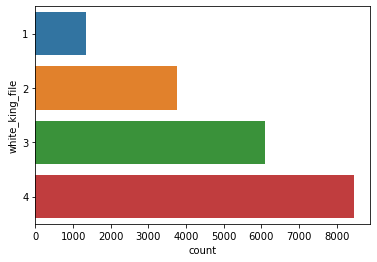

In [92]:
seaborn.countplot(y = "white_king_file", data = df_train.sort_values(by = "white_king_file"),orient="h")

<AxesSubplot:xlabel='count', ylabel='white_king_rank'>

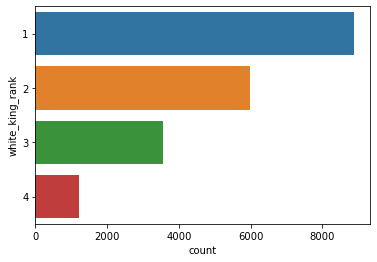

In [93]:
seaborn.countplot(y = "white_king_rank", data = df_train.sort_values(by = "white_king_rank"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black_king_file'>

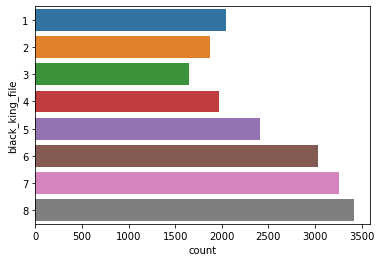

In [94]:
seaborn.countplot(y = "black_king_file", data = df_train.sort_values(by = "black_king_file"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black_king_rank'>

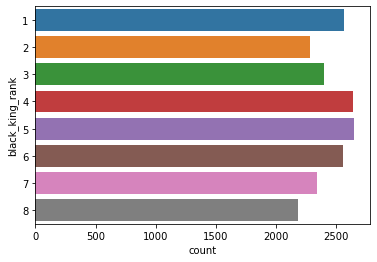

In [95]:
seaborn.countplot(y = "black_king_rank", data = df_train.sort_values(by = "black_king_rank"),orient="h")

<AxesSubplot:xlabel='count', ylabel='white_rook_rank'>

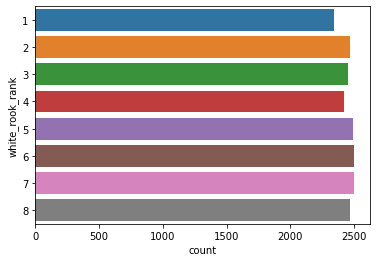

In [96]:
seaborn.countplot(y = "white_rook_rank", data = df_train.sort_values(by = "white_rook_rank"),orient="h")

<AxesSubplot:xlabel='count', ylabel='white_rook_file'>

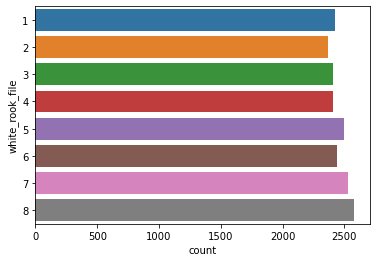

In [97]:
seaborn.countplot(y = "white_rook_file", data = df_train.sort_values(by = "white_rook_file"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black_king_dst'>

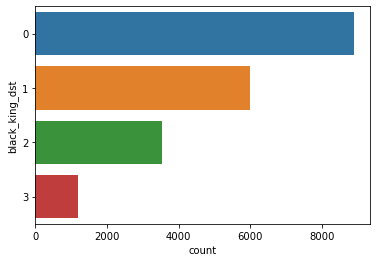

In [98]:
seaborn.countplot(y = "black_king_dst", data = df_train.sort_values(by = "black_king_dst"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black2white_king_dst'>

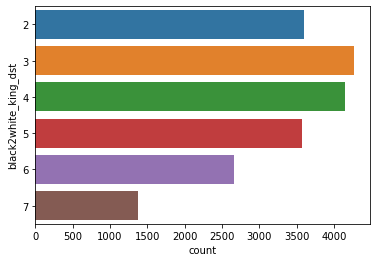

In [99]:
seaborn.countplot(y = "black2white_king_dst", data = df_train.sort_values(by = "black2white_king_dst"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black2rook_dst'>

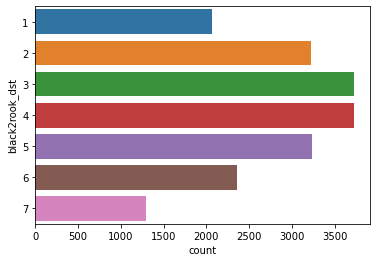

In [100]:
seaborn.countplot(y = "black2rook_dst", data = df_train.sort_values(by = "black2rook_dst"),orient="h")

<AxesSubplot:xlabel='result', ylabel='Count'>

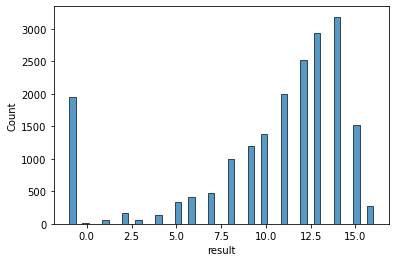

In [101]:
seaborn.histplot(x = "result", data = df_train)

In [102]:
df_train.corr()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst,black2rook_dst
white_king_file,1.000000,0.456087,-0.009108,0.000182,-0.140401,0.105595,-0.195264,-0.054697,-0.297172,0.025093
white_king_rank,0.456087,1.000000,0.008568,-0.008044,0.097899,-0.123493,-0.247554,-0.095732,-0.358309,0.036792
white_rook_file,-0.009108,0.008568,1.000000,-0.008674,-0.015768,-0.001490,-0.056035,0.013431,-0.016254,-0.132705
white_rook_rank,0.000182,-0.008044,-0.008674,1.000000,0.004017,-0.025332,0.001758,-0.008814,-0.004573,0.020399
black_king_file,-0.140401,0.097899,-0.015768,0.004017,1.000000,-0.075550,0.044304,-0.069412,0.268161,0.020694
black_king_rank,0.105595,-0.123493,-0.001490,-0.025332,-0.075550,1.000000,0.216334,0.027861,0.611104,-0.022466
result,-0.195264,-0.247554,-0.056035,0.001758,0.044304,0.216334,1.000000,0.230134,0.152326,0.350126
black_king_dst,-0.054697,-0.095732,0.013431,-0.008814,-0.069412,0.027861,0.230134,1.000000,-0.358527,-0.322727
black2white_king_dst,-0.297172,-0.358309,-0.016254,-0.004573,0.268161,0.611104,0.152326,-0.358527,1.000000,0.124789
black2rook_dst,0.025093,0.036792,-0.132705,0.020399,0.020694,-0.022466,0.350126,-0.322727,0.124789,1.000000


<AxesSubplot:>

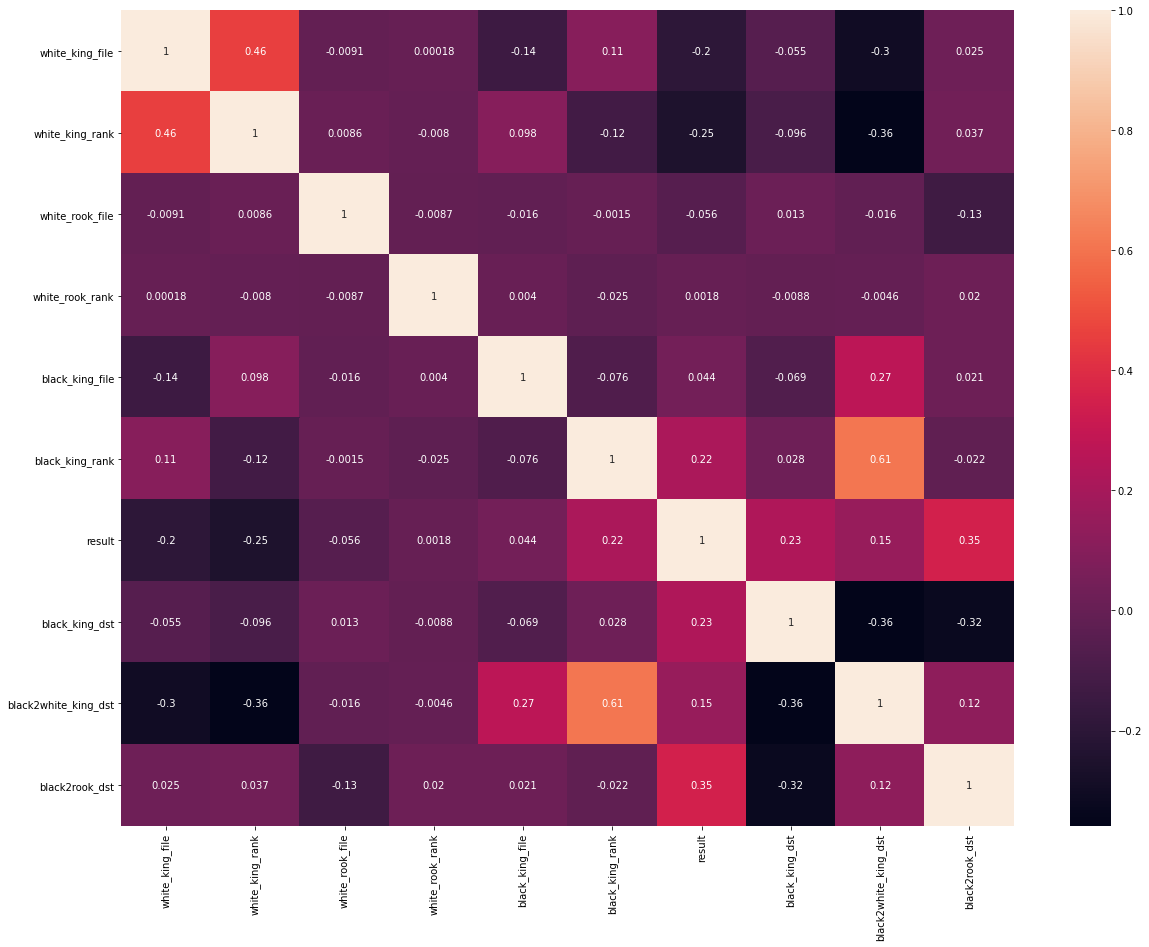

In [103]:
fig, ax = plt.subplots(figsize=(20, 15))
seaborn.heatmap(df_train.corr(),annot=True)

Większość graczy woli matować do jednej z poziomych krawędzi planszy

Nie wiadomo co zrobić z remisami - mogą zaburzać proces uczenia

In [131]:
%matplotlib inline

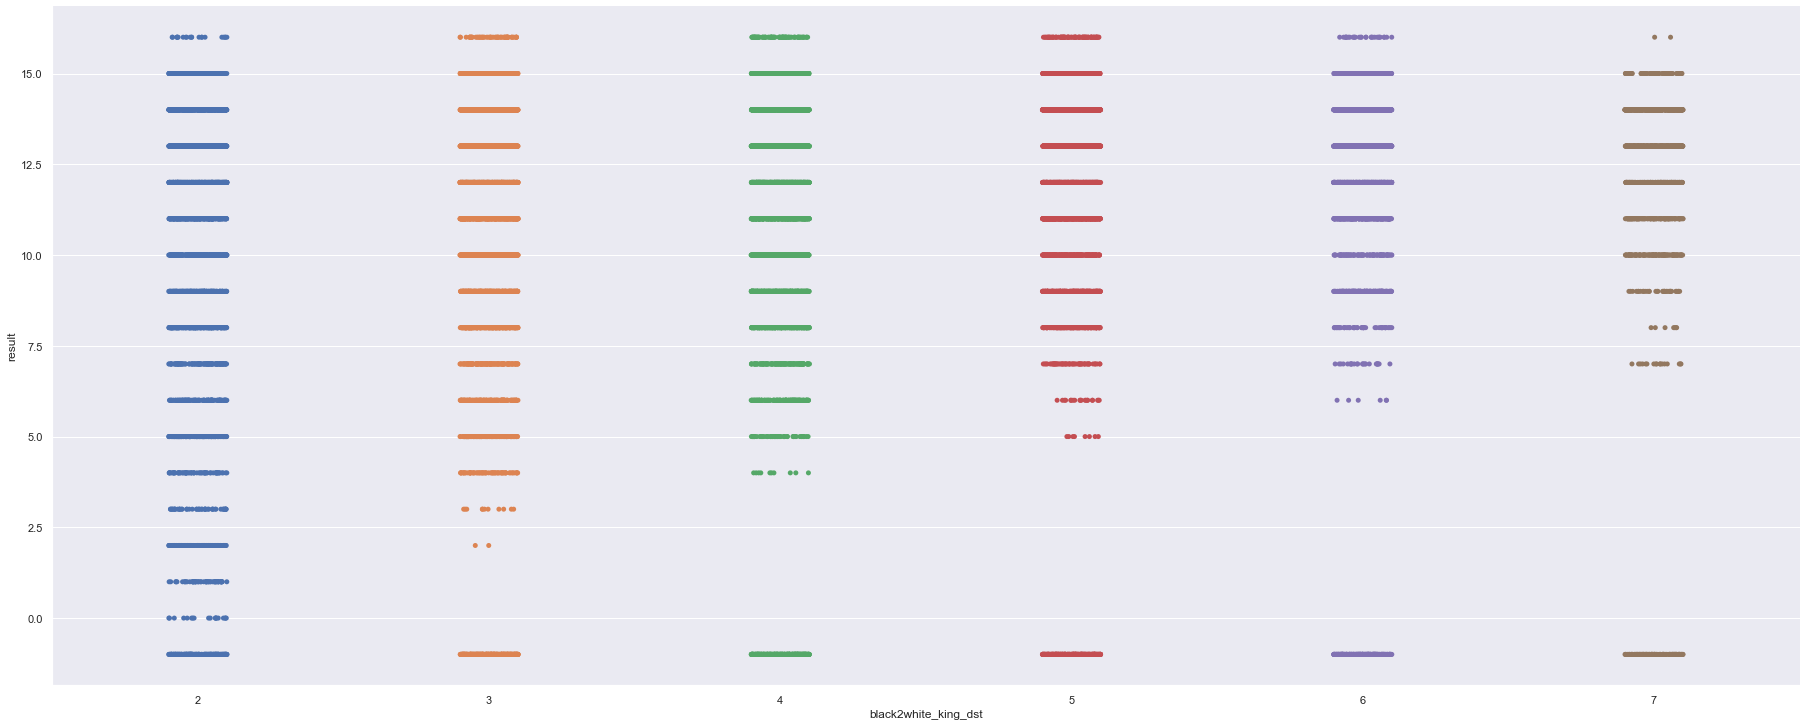

In [147]:

sns.catplot(x="black2white_king_dst", y="result", data=df_train,height=10,aspect=2.5)